In [1]:
import numpy as np
from scipy import integrate
import torch
import torch.autograd as autograd
import torch.nn as nn

from pyDOE import lhs
import scipy.io
import csv
import pprint
import matplotlib.pyplot as plt
import time

In [2]:
'''初期設定'''
torch.set_default_dtype(torch.float64)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name())

cuda


In [3]:
gamma=1.4
rgas=8.314e+03/28.96
cvgas=rgas/(gamma-1.0)

In [4]:
'''理論解の生成'''
x = np.arange(-2, 2.01, 0.01)
t = np.arange(0, 1.01, 0.01)
X, T = np.meshgrid(x, t)

p_exact = np.ones_like(X)

rho_exact = np.empty((t.shape[0],x.shape[0]))
for i in range(len(t)):
    for j in range(len(x)):
        if 1 * t[i] > x[j] :
            rho_exact[i,j] = 100
        else :
            rho_exact[i,j] = 1.0

u_exact = np.ones_like(X)

rho_max = np.max(rho_exact)
u_max = np.max(u_exact)
p_max = np.max(p_exact)

q0_exact = rho_exact/rho_max
q1_exact = u_exact/u_max
q2_exact = p_exact/p_max
Et_max = p_max/((gamma-1)*rho_max)+0.5*rho_max*u_max*u_max

In [5]:
Nx = 401
Nt = 101

X, T = np.meshgrid(x, t)
xt_test = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
#これは最後にテストするときに使う

# Domain bounds
lb = xt_test[0]  # [0. 0.]
ub = xt_test[-1] # [L, T]

q0_flat = q0_exact.flatten('F')[:,None]
q1_flat = q1_exact.flatten('F')[:,None]
q2_flat = q2_exact.flatten('F')[:,None]

q_exact = np.hstack((q0_flat, q1_flat, q2_flat))

In [6]:
'''評価点の設定'''
def trainingdata(N_ini, N_b_0, N_b_L, N_f):

    #Boundary Condition x = -L and 0 <= t <= T: Dirichlet conditions 
    xt_b_0 = np.hstack((X[:,0][:,None], T[:,0][:,None]))
    q0_b_0 = q0_exact[:,0][:,None]
    q1_b_0 = q1_exact[:,0][:,None]
    q2_b_0 = q2_exact[:,0][:,None]

    #Boundary Condition x = L and 0 <= t <= T: Dirichlet conditions
    xt_b_L = np.hstack((X[:,-1][:,None], T[:,0][:,None])) 
    q0_b_L = q0_exact[:,-1][:,None]
    q1_b_L = q1_exact[:,-1][:,None]
    q2_b_L = q2_exact[:,-1][:,None]
    
    #Initial Condition 0 <= x <= L and t = 0
    xt_ini = np.hstack((X[0,:][:,None], T[0,:][:,None]))
    q0_ini = q0_exact[0,:][:,None]
    q1_ini = q1_exact[0,:][:,None]
    q2_ini = q2_exact[0,:][:,None]

    #choose random N_u points for training boundary conditions
    idx_ini = np.random.choice(xt_ini.shape[0], N_ini, replace=False) 
    idx_b_0 = np.random.choice(xt_b_0.shape[0], N_b_0, replace=False)
    idx_b_L = np.random.choice(xt_b_L.shape[0], N_b_L, replace=False)

    xt_ini_train = xt_ini[idx_ini, :]
    u_ini_train = np.hstack((q0_ini[idx_ini,:],q1_ini[idx_ini,:],q2_ini[idx_ini,:]))

    xt_b_0_train = xt_b_0[idx_b_0,:]
    u_b_0_train = np.hstack((q0_b_0[idx_b_0,:],q1_b_0[idx_b_0,:],q2_b_0[idx_b_0,:]))
    
    xt_b_L_train = xt_b_L[idx_b_L,:]
    u_b_L_train = np.hstack((q0_b_L[idx_b_L,:],q1_b_L[idx_b_L,:],q2_b_L[idx_b_L,:]))

    #Collcation point generation by Latin Hypercube Sampling
    xt_f_train = lb + (ub-lb)*lhs(2,N_f) 

    return xt_ini_train,u_ini_train, xt_b_0_train,u_b_0_train, xt_b_L_train,u_b_L_train, xt_f_train

N_ini = 400
N_b_0 = 100
N_b_L = 100
N_f = 2000
xt_ini_train_np,u_ini_train_np, xt_b_0_train_np,u_b_0_train_np, xt_b_L_train_np,u_b_L_train_np, xt_f_train_np = trainingdata(N_ini, N_b_0, N_b_L, N_f)

#Convert to tensor and send to GPU
xt_ini_train = torch.from_numpy(xt_ini_train_np).double().to(device)
u_ini_train = torch.from_numpy(u_ini_train_np).double().to(device)
xt_b_0_train = torch.from_numpy(xt_b_0_train_np).double().to(device)
u_b_0_train = torch.from_numpy(u_b_0_train_np).double().to(device)
xt_b_L_train = torch.from_numpy(xt_b_L_train_np).double().to(device)
u_b_L_train = torch.from_numpy(u_b_L_train_np).double().to(device)
xt_f_train =  torch.from_numpy(xt_f_train_np).double().to(device)

xt_test_tensor = torch.from_numpy(xt_test).double().to(device)
u = torch.from_numpy(q_exact).double().to(device)

f_hat = torch.zeros(xt_f_train.shape[0],3).to(device)

In [7]:
'''モデル設計'''
class Sequentialmodel(nn.Module):
    
    def __init__(self,layers):
        super().__init__()
              
        'activation function'
        self.activation = nn.Tanh()

        'loss function'
        self.loss_function = nn.MSELoss(reduction ='mean')
    
        'Initialise neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        
        self.iter = 0
        
        self.loss_hist = []

        for i in range(len(layers)-1):
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            nn.init.zeros_(self.linears[i].bias.data)
    
    #foward computation
    def forward(self,x):
        
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x) 
        
        u_b = torch.from_numpy(ub).double().to(device)
        l_b = torch.from_numpy(lb).double().to(device)
                      
        #scaling
        x = (x - l_b)/(u_b - l_b)
        
        #convert to double
        a = x.double()

        for i in range(len(layers)-2):         
            z = self.linears[i](a)
            a = self.activation(z)

        a = self.linears[-1](a)
        
        return a

    #loss function induced from initial condition
    def loss_IC(self,xt,y):

        z = xt.clone()
        z.requires_grad = True
        
        u = self.forward(z)

        loss_u = self.loss_function(u, y)
                
        return loss_u

    #loss function induced from Diriclet boundary condition 
    def loss_BC(self,xt,y):
                
        loss_u = self.loss_function(self.forward(xt), y)
                
        return loss_u
    
    #loss function induced from governing equation
    def loss_PDE(self, xt):
                       
        z = xt.clone()
        z.requires_grad = True
        
        a = self.forward(z)
        
        a[:,0][:,None] = a[:,0][:,None]*rho_max
        a[:,1][:,None] = a[:,1][:,None]*u_max
        a[:,2][:,None] = a[:,2][:,None]*p_max
        
        Q_0 = a[:,0][:,None] 
        Q_1 = a[:,0][:,None] * a[:,1][:,None]
        Q_2 = a[:,2][:,None]/((gamma-1)*a[:,0][:,None]) + 0.5*a[:,0][:,None]*a[:,1][:,None]*a[:,1][:,None]
        
        Q_0_x_t = autograd.grad(Q_0,z,torch.ones([Q_0.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Q_1_x_t = autograd.grad(Q_1,z,torch.ones([Q_1.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        Q_2_x_t = autograd.grad(Q_2,z,torch.ones([Q_2.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        Q_0_t = Q_0_x_t[:,1][:,None]
        Q_1_t = Q_1_x_t[:,1][:,None]
        Q_2_t = Q_2_x_t[:,1][:,None]
        
        E_0 = a[:,0][:,None] * a[:,1][:,None]
        E_1 = a[:,0][:,None] * a[:,1][:,None] * a[:,1][:,None] + a[:,2][:,None]
        E_2 = (Q_2 + a[:,2][:,None])*a[:,1][:,None]
        
        
        E_0_x_t = autograd.grad(E_0,z,torch.ones([E_0.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        E_1_x_t = autograd.grad(E_1,z,torch.ones([E_1.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        E_2_x_t = autograd.grad(E_2,z,torch.ones([E_2.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        E_0_x = E_0_x_t[:,0][:,None]
        E_1_x = E_1_x_t[:,0][:,None]
        E_2_x = E_2_x_t[:,0][:,None]
        
        f_0 = Q_0_t + E_0_x
        f_1 = Q_1_t + E_1_x
        f_2 = Q_2_t + E_2_x
        
        f = torch.hstack((f_0/rho_max, f_1/(rho_max*u_max), f_2/Et_max))
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f
    
    def loss(self,xt_ini_train,u_ini_train, xt_b_0_train,u_b_0_train, xt_b_L_train,u_b_L_train, xt_f_train):

        loss_ini = self.loss_IC(xt_ini_train, u_ini_train)        
        loss_BC_0 = self.loss_BC(xt_b_0_train, u_b_0_train)
        loss_BC_L = self.loss_BC(xt_b_L_train, u_b_L_train)
        
        loss_f = self.loss_PDE(xt_f_train)
        
        loss_val = loss_ini + loss_BC_0 + loss_BC_L + loss_f
        
        return loss_val

    def closure(self):
        
        optimizer.zero_grad()
        loss = self.loss(xt_ini_train,u_ini_train, xt_b_0_train,u_b_0_train, xt_b_L_train,u_b_L_train, xt_f_train)
        self.loss_hist.append(loss.item())
        
        loss.backward()
                
        self.iter += 1
        if self.iter == 1:
            _ = PINN.test()
            print('step=',self.iter, ', loss=', loss.item())
        
        if self.iter % 100 == 0:
            _ = PINN.test()
            print('step=',self.iter, ', loss=', loss.item())

        return loss        
    
    def test(self):
                
        u_pred = self.forward(xt_test_tensor)
        u_pred = u_pred.cpu().detach().numpy()
        q0_pred = np.reshape(u_pred[:,[0]],(Nx,Nt),order='F')
        q1_pred = np.reshape(u_pred[:,[1]],(Nx,Nt),order='F')
        q2_pred = np.reshape(u_pred[:,[2]],(Nx,Nt),order='F')
        
        rho = q0_pred *rho_max
        vel = q1_pred *u_max
        pres = q2_pred *p_max
    
        
        return rho, vel, pres

In [ ]:
torch.manual_seed(1234)
np.random.seed(1234)

layers = np.array([2,20,20,20,20,20,20,20,20,3])

PINN = Sequentialmodel(layers)
PINN.to(device)

print(PINN)
#%%
'''最適化'''
params = list(PINN.parameters())
print("start")
start = time.time()


optimizer = torch.optim.Adam(PINN.parameters(), lr = 0.01, eps = 1e-7)
for _ in range(1000):
    optimizer.step(PINN.closure)


print("change optimizer")
optimizer = torch.optim.LBFGS(PINN.parameters(), lr=0.01, 
                              max_iter = 8000, 
                              max_eval = 8000, 
                              tolerance_grad = 1e-10, 
                              tolerance_change = 1e-10, 
                              history_size = 100,
                              line_search_fn = 'strong_wolfe')


optimizer.step(PINN.closure)

hist_lbfgs = PINN.loss_hist
process_time = time.time() - start
print("end")
print(process_time)

Sequentialmodel(
  (activation): Tanh()
  (loss_function): MSELoss()
  (linears): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=20, bias=True)
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=20, bias=True)
    (4): Linear(in_features=20, out_features=20, bias=True)
    (5): Linear(in_features=20, out_features=20, bias=True)
    (6): Linear(in_features=20, out_features=20, bias=True)
    (7): Linear(in_features=20, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=3, bias=True)
  )
)
start
step= 1 , loss= 9718580.380817672
step= 100 , loss= 10.60530817713402
step= 200 , loss= 10.605559228284424
step= 300 , loss= 10.605538544062687
step= 400 , loss= 10.605513382053891
step= 500 , loss= 10.60548406760152
step= 600 , loss= 10.605450762436366
step= 700 , loss= 10.60541354218158
step= 800 , loss= 10.605372427091982
step= 900 , loss= 10.60532739

In [11]:
'''解の可視化'''
rho_pinn, u_pinn, p_pinn = PINN.test()

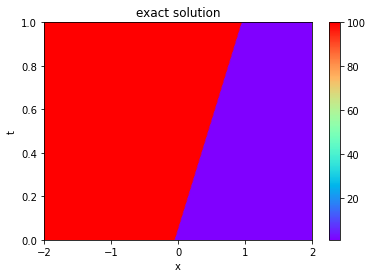

In [15]:
x_eval = np.ravel(X.T).reshape(-1, 1)
t_eval = np.ravel(T.T).reshape(-1, 1)

xmax = np.max(x_eval)
xmin = np.min(x_eval)
tmax = np.max(t_eval)

fig = plt.figure()
plt.ylim(0, tmax)
plt.xlim(xmin, xmax)
plt.xlabel('x')
plt.ylabel('t')
plt.scatter(x_eval, t_eval, c=rho_exact.T.reshape(-1,1), vmin=np.min(rho_exact), vmax=np.max(rho_exact), cmap='rainbow')
plt.colorbar()
plt.title('exact solution')
plt.show()
fig.savefig("exact.png")

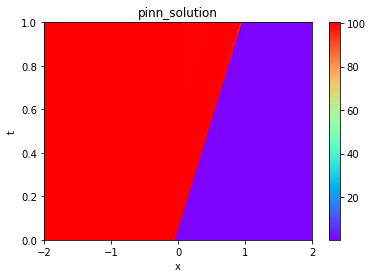

In [13]:
x_eval = np.ravel(X.T).reshape(-1, 1)
t_eval = np.ravel(T.T).reshape(-1, 1)

xmax = np.max(x_eval)
xmin = np.min(x_eval)
tmax = np.max(t_eval)

fig = plt.figure()
plt.ylim(0, tmax)
plt.xlim(xmin, xmax)
plt.xlabel('x')
plt.ylabel('t')
plt.scatter(x_eval, t_eval, c=rho_pinn.reshape(-1, 1), vmin = np.min(rho_pinn), vmax=np.max(rho_pinn) , cmap='rainbow')
plt.colorbar()
plt.title('pinn_solution')
plt.show()
#fig.savefig("pinn_1235.jpeg")


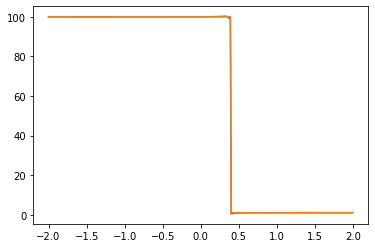

In [17]:
plt.plot(X[40,:], rho_pinn.T[40,:])
plt.plot(X[40,:], rho_exact[40,:])